# Building a Recommendation System for the MovieLens Dataset - Data Import, Preprocessing, EDA

Nick Pasternak (nfp5ga), Kara Fallin (kmf4tg), Aparna Marathe (am7ad)

In this notebook we load, process, and explore the data. Some of the data comes from the MovieLens data set while another portion was web scraped from the IMDB site. The web scraping code is located in a separate python file. Additionally, we load and process the data again in our three model building notebooks. 

In [1]:
import pyspark
import os
import pyspark.sql.types as typ
import pyspark.sql.functions as F
from pyspark.sql.functions import col, asc, desc, split, regexp_extract, explode
from pyspark.mllib import recommendation
from pyspark.mllib.recommendation import *
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark.sql.types import IntegerType, FloatType
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local") \
    .appName("data preprocessing") \
    .config("spark.executor.memory", '8g') \
    .config('spark.executor.cores', '4') \
    .config('spark.cores.max', '4') \
    .config("spark.driver.memory",'8g') \
    .getOrCreate()

sc = spark.sparkContext

In [3]:
os.chdir('/project/ds5559/group10_reviews')
os.getcwd()

'/project/ds5559/group10_reviews'

## Load the data

### Movie links: links to imdb website 

(https://www.imdb.com/title/tt0 + imdbId + /?ref_=fn_al_tt_1)

In [4]:
links = spark.read.csv("/project/ds5559/group10_reviews/link.csv", header=True)
links.show()

+-------+------+------+
|movieId|imdbId|tmdbId|
+-------+------+------+
|      1|114709|   862|
|      2|113497|  8844|
|      3|113228| 15602|
|      4|114885| 31357|
|      5|113041| 11862|
|      6|113277|   949|
|      7|114319| 11860|
|      8|112302| 45325|
|      9|114576|  9091|
|     10|113189|   710|
|     11|112346|  9087|
|     12|112896| 12110|
|     13|112453| 21032|
|     14|113987| 10858|
|     15|112760|  1408|
|     16|112641|   524|
|     17|114388|  4584|
|     18|113101|     5|
|     19|112281|  9273|
|     20|113845| 11517|
+-------+------+------+
only showing top 20 rows



In [5]:
links.count()

27278

### Movies

In [6]:
movies = spark.read.csv("/project/ds5559/group10_reviews/movie.csv", header=True)
movies = movies.withColumn('genres',split(col('genres'),"[|]"))
movies = movies.withColumn('year',regexp_extract('title', r'(.*)\((\d+)\)', 2))
movies = movies.withColumn('title',regexp_extract('title', r'(.*) \((\d+)\)', 1))
movies.show()

+-------+--------------------+--------------------+----+
|movieId|               title|              genres|year|
+-------+--------------------+--------------------+----+
|      1|           Toy Story|[Adventure, Anima...|1995|
|      2|             Jumanji|[Adventure, Child...|1995|
|      3|    Grumpier Old Men|   [Comedy, Romance]|1995|
|      4|   Waiting to Exhale|[Comedy, Drama, R...|1995|
|      5|Father of the Bri...|            [Comedy]|1995|
|      6|                Heat|[Action, Crime, T...|1995|
|      7|             Sabrina|   [Comedy, Romance]|1995|
|      8|        Tom and Huck|[Adventure, Child...|1995|
|      9|        Sudden Death|            [Action]|1995|
|     10|           GoldenEye|[Action, Adventur...|1995|
|     11|American Presiden...|[Comedy, Drama, R...|1995|
|     12|Dracula: Dead and...|    [Comedy, Horror]|1995|
|     13|               Balto|[Adventure, Anima...|1995|
|     14|               Nixon|             [Drama]|1995|
|     15|    Cutthroat Island|[

In [7]:
movies.count()

27278

### User ratings

In [8]:
ratings = spark.read.csv("/project/ds5559/group10_reviews/rating.csv", header=True).drop('timestamp')
ratings.show()

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      2|   3.5|
|     1|     29|   3.5|
|     1|     32|   3.5|
|     1|     47|   3.5|
|     1|     50|   3.5|
|     1|    112|   3.5|
|     1|    151|     4|
|     1|    223|     4|
|     1|    253|     4|
|     1|    260|     4|
|     1|    293|     4|
|     1|    296|     4|
|     1|    318|     4|
|     1|    337|   3.5|
|     1|    367|   3.5|
|     1|    541|     4|
|     1|    589|   3.5|
|     1|    593|   3.5|
|     1|    653|     3|
|     1|    919|   3.5|
+------+-------+------+
only showing top 20 rows



In [9]:
ratings.count()

20000263

-----------

## Process the data

### Merge existing data

In [10]:
df1 = ratings.join(movies,on="movieId",how="inner")
df1.show()

+-------+------+------+--------------------+--------------------+----+
|movieId|userId|rating|               title|              genres|year|
+-------+------+------+--------------------+--------------------+----+
|      2|     1|   3.5|             Jumanji|[Adventure, Child...|1995|
|     29|     1|   3.5|City of Lost Chil...|[Adventure, Drama...|1995|
|     32|     1|   3.5|Twelve Monkeys (a...|[Mystery, Sci-Fi,...|1995|
|     47|     1|   3.5|Seven (a.k.a. Se7en)| [Mystery, Thriller]|1995|
|     50|     1|   3.5| Usual Suspects, The|[Crime, Mystery, ...|1995|
|    112|     1|   3.5|Rumble in the Bro...|[Action, Adventur...|1995|
|    151|     1|     4|             Rob Roy|[Action, Drama, R...|1995|
|    223|     1|     4|              Clerks|            [Comedy]|1994|
|    253|     1|     4|Interview with th...|     [Drama, Horror]|1994|
|    260|     1|     4|Star Wars: Episod...|[Action, Adventur...|1977|
|    293|     1|     4|Léon: The Profess...|[Action, Crime, D...|1994|
|    2

In [11]:
df1.count()

20000263

In [12]:
df2 = df1.join(links,on=['movieId'],how='inner').drop('tmdbId')
df2.show()

+-------+------+------+--------------------+--------------------+----+------+
|movieId|userId|rating|               title|              genres|year|imdbId|
+-------+------+------+--------------------+--------------------+----+------+
|      2|     1|   3.5|             Jumanji|[Adventure, Child...|1995|113497|
|     29|     1|   3.5|City of Lost Chil...|[Adventure, Drama...|1995|112682|
|     32|     1|   3.5|Twelve Monkeys (a...|[Mystery, Sci-Fi,...|1995|114746|
|     47|     1|   3.5|Seven (a.k.a. Se7en)| [Mystery, Thriller]|1995|114369|
|     50|     1|   3.5| Usual Suspects, The|[Crime, Mystery, ...|1995|114814|
|    112|     1|   3.5|Rumble in the Bro...|[Action, Adventur...|1995|113326|
|    151|     1|     4|             Rob Roy|[Action, Drama, R...|1995|114287|
|    223|     1|     4|              Clerks|            [Comedy]|1994|109445|
|    253|     1|     4|Interview with th...|     [Drama, Horror]|1994|110148|
|    260|     1|     4|Star Wars: Episod...|[Action, Adventur...

In [13]:
df2.count()

20000263

In [14]:
scrape = spark.read.csv("/project/ds5559/group10_reviews/movie_scrape.csv", header=True)
scrape = scrape.drop('title','year', 'genres')
scrape.show()

+------+---------+-----+--------------------+
|imdbId| category|score|         description|
+------+---------+-----+--------------------+
| 47437|   Passed|  7.6|Linus and David L...|
| 82971|       PG|  8.4|The year is 1936....|
|100263|        R|  7.3|An urgent life-or...|
|102536|        R|  7.7|A collection of f...|
| 13442|Not Rated|  7.9|Wisbourg, Germany...|
|105435|    PG-13|  7.1|Martin Bishop is ...|
|120207|    PG-13|  3.0|"John Henry Irons...|
|119675|        R|  6.0|A disease carried...|
|119655|     null|  5.7|"In a world where...|
|120478|       PG|  5.3|Shy seventh-grade...|
|101272|    PG-13|  6.9|The Addams Family...|
| 46534|        G|  7.0|H.G. Wells' class...|
| 60095| Approved|  6.3|Suave former Texa...|
| 67525|       PG|  6.4|"Due to an experi...|
| 97717|        R|  3.9|"""Porky"" style ...|
|158371|    PG-13|  7.2|A comedic biopic ...|
|104454|       PG|  7.4|Encounter of thre...|
|110629|     1994|  2.8|Sam and Dave are ...|
|160009|        R|  5.7|Shaw is an

In [15]:
scrape.count()

27282

In [16]:
df = df2.join(scrape,on='imdbId',how='inner')
df.show()

+------+-------+------+------+--------------------+--------------------+----+--------+-----+--------------------+
|imdbId|movieId|userId|rating|               title|              genres|year|category|score|         description|
+------+-------+------+------+--------------------+--------------------+----+--------+-----+--------------------+
|113497|      2|     1|   3.5|             Jumanji|[Adventure, Child...|1995|      PG|  7.0|Jumanji, one of t...|
|112682|     29|     1|   3.5|City of Lost Chil...|[Adventure, Drama...|1995|       R|  7.5|Set in a dystopia...|
|114746|     32|     1|   3.5|Twelve Monkeys (a...|[Mystery, Sci-Fi,...|1995|       R|  8.0|James Cole, a pri...|
|114369|     47|     1|   3.5|Seven (a.k.a. Se7en)| [Mystery, Thriller]|1995|       R|  8.6|A film about two ...|
|114814|     50|     1|   3.5| Usual Suspects, The|[Crime, Mystery, ...|1995|       R|  8.5|Following a truck...|
|113326|    112|     1|   3.5|Rumble in the Bro...|[Action, Adventur...|1995|       R|  

In [17]:
df.count()

20000263

In [18]:
df = df.drop('imdbId')
df.show()

+-------+------+------+--------------------+--------------------+----+--------+-----+--------------------+
|movieId|userId|rating|               title|              genres|year|category|score|         description|
+-------+------+------+--------------------+--------------------+----+--------+-----+--------------------+
|      2|     1|   3.5|             Jumanji|[Adventure, Child...|1995|      PG|  7.0|Jumanji, one of t...|
|     29|     1|   3.5|City of Lost Chil...|[Adventure, Drama...|1995|       R|  7.5|Set in a dystopia...|
|     32|     1|   3.5|Twelve Monkeys (a...|[Mystery, Sci-Fi,...|1995|       R|  8.0|James Cole, a pri...|
|     47|     1|   3.5|Seven (a.k.a. Se7en)| [Mystery, Thriller]|1995|       R|  8.6|A film about two ...|
|     50|     1|   3.5| Usual Suspects, The|[Crime, Mystery, ...|1995|       R|  8.5|Following a truck...|
|    112|     1|   3.5|Rumble in the Bro...|[Action, Adventur...|1995|       R|  6.7|Keong comes from ...|
|    151|     1|     4|             R

In [19]:
df = df.withColumn('movieId', col('movieId').cast(IntegerType()))
df = df.withColumn('userId', col('userId').cast(IntegerType()))
df = df.withColumn('rating', col('rating').cast(FloatType()))
df = df.withColumn('year', col('year').cast(IntegerType()))
df = df.withColumn('score', col('score').cast(FloatType()))

In [20]:
df.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- userId: integer (nullable = true)
 |-- rating: float (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- year: integer (nullable = true)
 |-- category: string (nullable = true)
 |-- score: float (nullable = true)
 |-- description: string (nullable = true)



----------------------

## Explore the data

In [21]:
# number of columns
len(df.columns)

9

In [22]:
# target variable summary
df.describe("rating").show()

+-------+------------------+
|summary|            rating|
+-------+------------------+
|  count|          20000263|
|   mean|3.5255285642993797|
| stddev| 1.051988919294229|
|    min|               0.5|
|    max|               5.0|
+-------+------------------+



In [23]:
# predictor variables summary
df.describe([col for col in df.columns if col in ['year','score']]).show()

+-------+------------------+------------------+
|summary|              year|             score|
+-------+------------------+------------------+
|  count|          19999858|          19984017|
|   mean|1991.5156462610885| 7.201700837581482|
| stddev|14.191408119108827|0.9459575939889878|
|    min|              1891|               1.3|
|    max|              2015|               9.4|
+-------+------------------+------------------+



In [24]:
df.filter(col('rating') == '3.5').describe('score').show()

+-------+------------------+
|summary|             score|
+-------+------------------+
|  count|           2198764|
|   mean| 7.233130991724717|
| stddev|0.8019640790753377|
|    min|               1.4|
|    max|               9.4|
+-------+------------------+



In [25]:
df.filter(col('rating') == '4').describe('score').show()

+-------+------------------+
|summary|             score|
+-------+------------------+
|  count|           5556801|
|   mean| 7.384075284844735|
| stddev|0.7866036281461439|
|    min|               1.7|
|    max|               9.4|
+-------+------------------+



In [26]:
df.filter(col('rating') == '4.5').describe('score').show()

+-------+------------------+
|summary|             score|
+-------+------------------+
|  count|           1533214|
|   mean|7.6922549232768525|
| stddev|0.7193399844027039|
|    min|               1.7|
|    max|               9.4|
+-------+------------------+



In [27]:
df.filter(col('rating') == '5').describe('score').show()

+-------+------------------+
|summary|             score|
+-------+------------------+
|  count|           2893888|
|   mean|7.7233097783895825|
| stddev|0.7806390327191743|
|    min|               1.3|
|    max|               9.4|
+-------+------------------+



<AxesSubplot:ylabel='Frequency'>

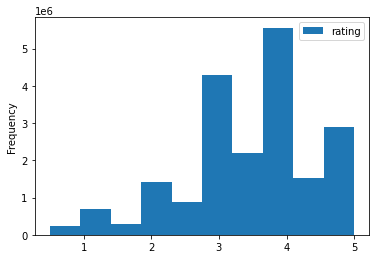

In [28]:
%matplotlib inline
import pandas as pd
x = df.select(col('rating').cast('float').alias('rating')).toPandas()
x.plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

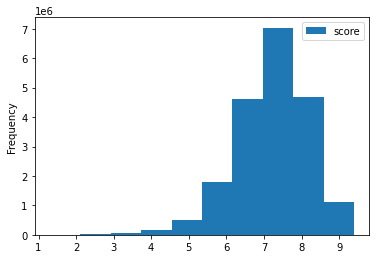

In [29]:
%matplotlib inline
import pandas as pd
x = df.select(col('score').cast('float').alias('score')).toPandas()
x.plot(kind='hist')

In [30]:
df.select(col('rating').cast('float').alias('rating'), explode(df.genres)).groupby('col').agg(F.mean('rating')).sort(col('avg(rating)'), ascending=False).show()

+------------------+------------------+
|               col|       avg(rating)|
+------------------+------------------+
|         Film-Noir|  3.96538126070082|
|               War|3.8095307347384844|
|       Documentary|3.7397176834178865|
|             Crime|3.6745276025631113|
|             Drama|3.6742955093068264|
|           Mystery| 3.663508921312903|
|              IMAX| 3.655945983272606|
|         Animation|3.6174939235897994|
|           Western|3.5704980246109406|
|           Musical| 3.558090628821412|
|           Romance| 3.541802581902903|
|          Thriller|  3.50711121809216|
|           Fantasy|3.5059453358738244|
|         Adventure|3.5018926565473865|
|            Action|  3.44386376493354|
|            Sci-Fi|3.4367726714455005|
|            Comedy|3.4260113054324886|
|          Children|3.4081137685270444|
|            Horror|3.2772238097518307|
|(no genres listed)|3.0069252077562325|
+------------------+------------------+



In [31]:
df.select(col('score').cast('float').alias('score'), explode(df.genres)).groupby('col').agg(F.mean('score')).sort(col('avg(score)'), ascending=False).show()

+------------------+------------------+
|               col|        avg(score)|
+------------------+------------------+
|         Film-Noir| 7.817592510845813|
|               War|  7.78039089870821|
|              IMAX| 7.625594798003999|
|       Documentary| 7.588305975130544|
|         Animation| 7.548295050509254|
|             Crime| 7.503955968670933|
|             Drama|  7.45389545684855|
|           Mystery| 7.448894842607299|
|           Musical| 7.441691877710254|
|           Western| 7.373610239577012|
|           Fantasy| 7.248032444165451|
|         Adventure| 7.236652543129051|
|          Thriller| 7.173763825852716|
|          Children|7.1465894945867365|
|            Sci-Fi| 7.131651234233853|
|           Romance| 7.119683861139643|
|            Action| 7.106014478047541|
|            Comedy| 6.975575977424163|
|            Horror|6.8911118482389275|
|(no genres listed)| 6.386349220881386|
+------------------+------------------+

